In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [5]:
engine = create_engine("sqlite:///../Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Station = Base.classes.station
Measurement = Base.classes.measurement

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

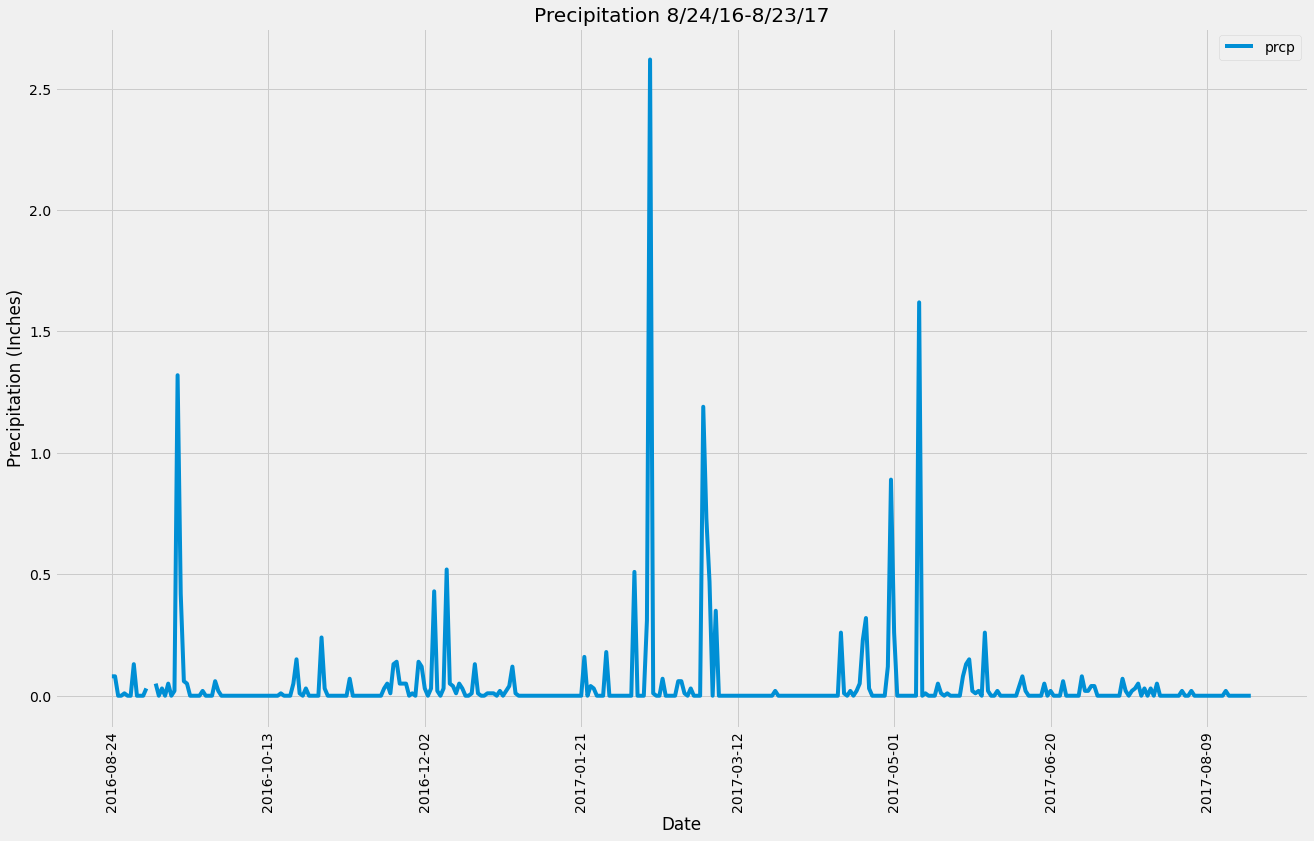

<Figure size 432x288 with 0 Axes>

In [10]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

# Calculate the date 1 year ago from the last data point in the database
latest_date=session.query(Measurement.date).order_by((Measurement.date).desc()).first()

# Perform a query to retrieve the data and precipitation scores
first_date = dt.date(2017,8,23) - dt.timedelta(days=365)

precip_data=session.query(Measurement.date, Measurement.prcp).group_by(Measurement.date)\
    .order_by(Measurement.date).filter(Measurement.date>first_date).statement

# Save the query results as a Pandas DataFrame and set the index to the date column
precip_df = pd.read_sql_query(precip_data, session.bind, index_col='date')

# Sort the dataframe by date
sort_df=precip_df.sort_index

# Use Pandas Plotting with Matplotlib to plot the data
precip_df.plot(kind='line', grid=True, figsize=(20,12),
              title="Precipitation 8/24/16-8/23/17", rot=90)
plt.xlabel("Date")
plt.ylabel("Precipitation (Inches)")
plt.show()
plt.tight_layout()


In [11]:
# Use Pandas to calculate the summary statistics for the precipitation data
precip_df.describe()

,prcp
count,363.000000
mean,0.048843
std,0.205197
min,0.000000
25%,0.000000
50%,0.000000
75%,0.020000
max,2.620000


In [12]:
# Design a query to show how many stations are available in this dataset?
station_count=session.query(Station.station).count()
print(f'Station count: {station_count}')

Station count: 9


In [13]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.

active_stations=session.query(Measurement.station, func.count(Measurement.station))\
    .group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).all()

active_stations 

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [14]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
session.query(func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs))\
              .filter(Measurement.station=='USC00519281').all()

[(54.0, 85.0, 71.66378066378067)]

In [15]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station
session.query(Measurement.tobs, Measurement.station, func.count(Measurement.tobs))\
            .group_by(Measurement.station).order_by(func.count(Measurement.tobs).desc()).all()

#Determined that temp_station with highest number of temperature observations is also USC00519281
temp_history=session.query(Measurement.tobs)\
            .filter(Measurement.station=='USC00519281').statement


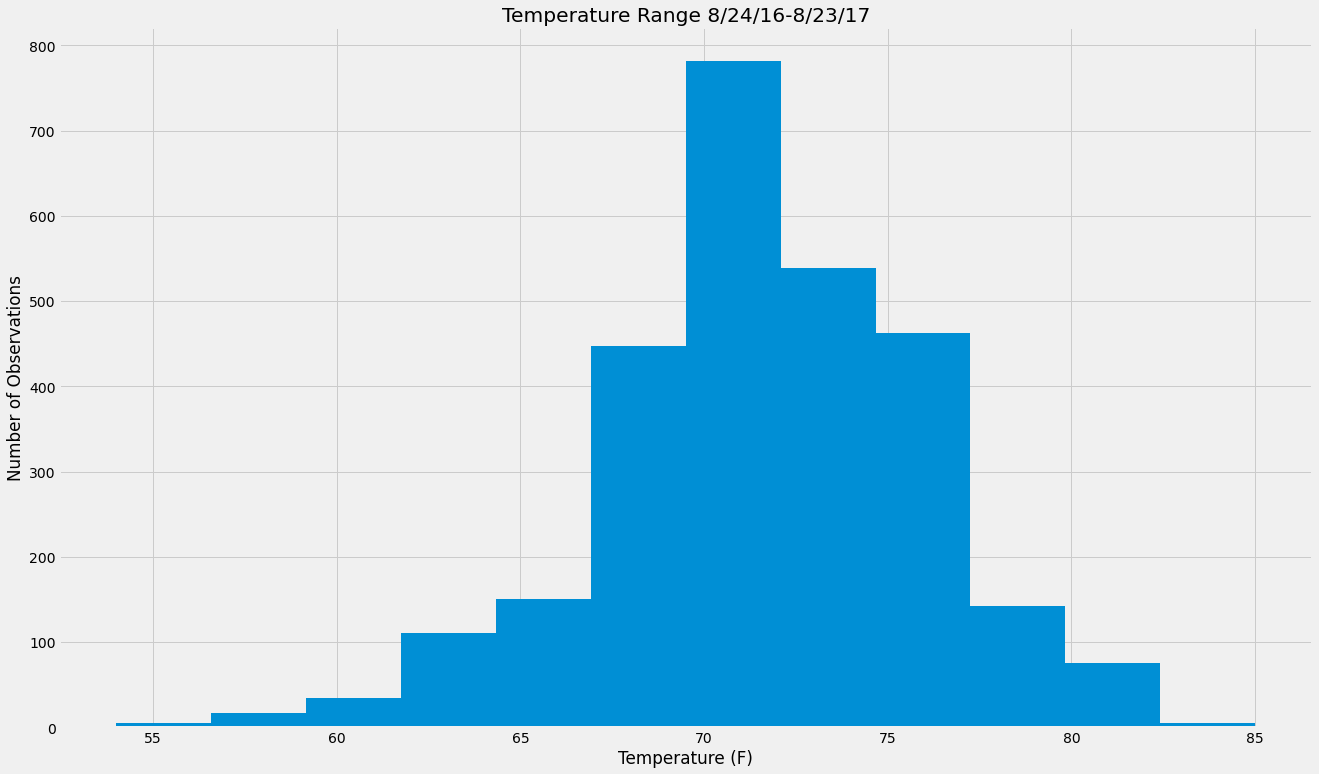

<Figure size 432x288 with 0 Axes>

In [16]:
#Plot the results as a histogram
temp_df = pd.read_sql_query(temp_history, session.bind)

# Use Pandas Plotting with Matplotlib to plot the data
temp_df.hist(bins=12, grid=True, figsize=(20,12))
plt.xlabel("Temperature (F)")
plt.ylabel("Number of Observations")
plt.title("Temperature Range 8/24/16-8/23/17")
plt.show()
plt.tight_layout()

## Bonus Challenge Assignment

In [17]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates

def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()



In [18]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.

start_date='2016-09-08'
end_date='2016-09-15'

print(calc_temps('2016-09-08', '2016-09-15'))

tmin, tave, tmax = calc_temps('2016-09-08', '2016-09-15')[0]

[(71.0, 77.3076923076923, 83.0)]


(0.0, 110.0)

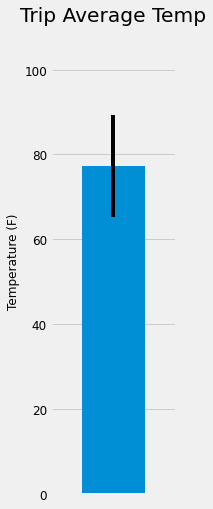

In [19]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)

avg_temps = pd.Series(tave).plot(kind='bar', title ="Trip Average Temp", figsize=(2,8), fontsize=12, yerr=(tmax-tmin))
avg_temps.set_ylabel("Temperature (F)",fontsize=12)
x_axis = avg_temps.axes.get_xaxis()
x_axis.set_visible(False)
plt.ylim((0,110))


In [20]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
station_data=session.query(Station.station, Station.name, Station.latitude, Station.longitude, Station.elevation).statement

measurements=session.query(Measurement.prcp, Measurement.station)\
            .filter(Measurement.date >= start_date)\
            .filter(Measurement.date <= end_date).group_by(Measurement.station)\
            .order_by(func.sum(Measurement.prcp).desc()).statement

station_df=pd.read_sql_query(station_data, session.bind)
measurement_df=pd.read_sql_query(measurements, session.bind)

combined_df=pd.merge(measurement_df, station_df, how='outer')
combined_df=combined_df.sort_values(by='prcp', ascending=False)
combined_df

,prcp,station,name,latitude,longitude,elevation
4,0.22,USC00513117,"KANEOHE 838.1, HI US",21.42340,-157.80150,14.6
0,0.15,USC00516128,"MANOA LYON ARBO 785.2, HI US",21.33310,-157.80250,152.4
1,0.07,USC00519281,"WAIHEE 837.5, HI US",21.45167,-157.84889,32.9
2,0.01,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.52130,-157.83740,7.0
3,0.01,USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",21.33556,-157.71139,19.5
5,0.00,USC00519397,"WAIKIKI 717.2, HI US",21.27160,-157.81680,3.0
6,NaN,USC00517948,"PEARL CITY, HI US",21.39340,-157.97510,11.9
7,NaN,USC00518838,"UPPER WAHIAWA 874.3, HI US",21.49920,-158.01110,306.6
8,NaN,USC00511918,"HONOLULU OBSERVATORY 702.2, HI US",21.31520,-157.99920,0.9


In [21]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("09-08")

[(66.0, 76.22222222222223, 83.0)]

In [22]:
# Use the start and end date to create a range of dates
start_day = dt.date(2016, 9, 8)
end_day = dt.date(2016, 9, 15)
delta = dt.timedelta(days=1)
combined_date=[]

# Strip off the year and save a list of %m-%d strings
while start_day <= end_day:
    format_date=start_day.strftime("%m-%d")
    combined_date.append(format_date)
    start_day += delta

    # Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
data_df = pd.DataFrame(columns = ['Date', 'TMIN', 'TAVE', 'TMAX'])
for date in combined_date:
    tmin, tave, tmax = daily_normals(date)[0]
    data_df = data_df.append(pd.DataFrame({
        'Date': [date+'-2016'],
        'TMIN': [tmin],
        'TAVE': [tave],
        'TMAX': [tmax]
    }))
data_df.set_index('Date')
data_df

,Date,TMIN,TAVE,TMAX
0,09-08-2016,66.0,76.222222,83.0
0,09-09-2016,68.0,76.365385,84.0
0,09-10-2016,67.0,76.612245,85.0
0,09-11-2016,70.0,76.695652,83.0
0,09-12-2016,68.0,75.897959,85.0
0,09-13-2016,68.0,75.875000,82.0
0,09-14-2016,69.0,75.980769,85.0
0,09-15-2016,67.0,76.140000,81.0


<AxesSubplot:xlabel='Date', ylabel='Temperature (F)'>

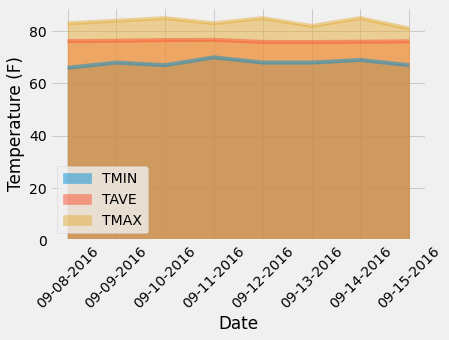

In [23]:
# Plot the daily normals as an area plot with `stacked=False`
data_df.plot.area(x='Date',ylabel='Temperature (F)', stacked=False, rot=45)